Random lesion segmentation file: /ImagePTE1/ajoshi/data/BRATS2018/Training/HGG/Brats18_CBICA_AYI_1/Brats18_CBICA_AYI_1_segmni.nii.gz
random normal subject t1 file: /ImagePTE1/ajoshi/data/camcan_preproc/sub-CC410248/T1mni.nii.gz


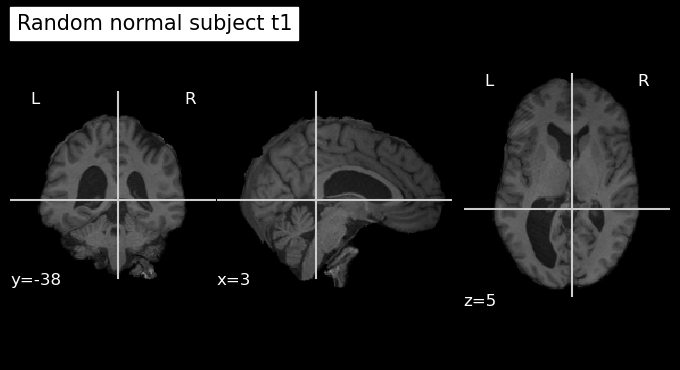

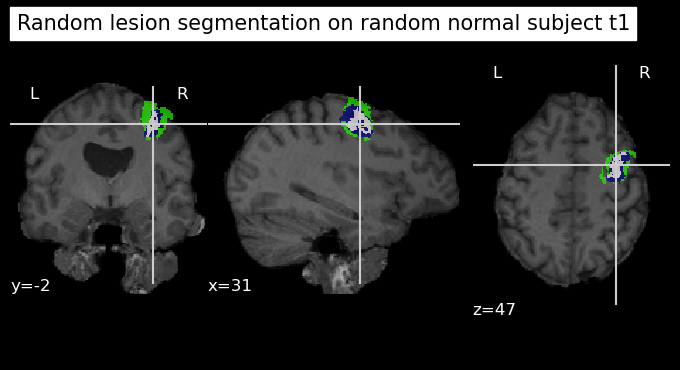

In [1]:

import os
import random
import SimpleITK as sitk
import numpy as np
import nilearn.image as ni
from nilearn.plotting import plot_anat, plot_roi

# This function reads a random lesion segmentation file from the BRATS dataset
def read_random_lesion_segmentation(brats_data_dir):
    # Get a list of patient directories in the BRATS dataset
    patient_dirs = [d for d in os.listdir(brats_data_dir)]

    # Randomly select a patient directory
    random_patient = random.choice(patient_dirs)

    # Get the segmentation file path (assuming the segmentation file is in the "seg" subdirectory)
    random_segmentation_file = os.path.join(brats_data_dir, random_patient, random_patient+'_segmni.nii.gz')
    #segmentation_files = [f for f in os.listdir(segmentation_dir) if f.endswith('.nii.gz')]
    
    if not random_segmentation_file:
        print(f"No segmentation files found for patient {random_segmentation_file}")
        return None

    return random_segmentation_file


# This function reads a random normal subject t1 file from the camcan dataset
def read_random_normal_subject(norm_data_dir):
    # Get a list of patient directories in the BRATS dataset
    sub_dirs = [d for d in os.listdir(norm_data_dir) if os.path.isdir(os.path.join(norm_data_dir, d))]

    # Randomly select a patient directory
    random_patient = random.choice(sub_dirs)

    # Get the segmentation file path (assuming the segmentation file is in the "seg" subdirectory)
    random_subject_file = os.path.join(norm_data_dir, random_patient, 'T1mni.nii.gz')
    #segmentation_files = [f for f in os.listdir(segmentation_dir) if f.endswith('.nii.gz')]
    
    if not random_subject_file:
        print(f"No segmentation files found for patient {random_subject_file}")
        return None

    return random_subject_file


# Example usage:
brats_data_directory = '/ImagePTE1/ajoshi/data/BRATS2018/Training/HGG'
norm_data_directory = '/ImagePTE1/ajoshi/data/camcan_preproc'
random_lesion_segmentation = read_random_lesion_segmentation(brats_data_directory)
#random_normal_subject = read_random_normal_subject(brats_data_directory)


print(f"Random lesion segmentation file: {random_lesion_segmentation}")

random_normal_t1 = read_random_normal_subject(norm_data_directory)

print(f'random normal subject t1 file: {random_normal_t1}' )

#plot_anat(random_lesion_segmentation, title='Random lesion segmentation')
plot_anat(random_normal_t1, title='Random normal subject t1')

plot_roi(roi_img=random_lesion_segmentation, bg_img=random_normal_t1, title='Random lesion segmentation on random normal subject t1')

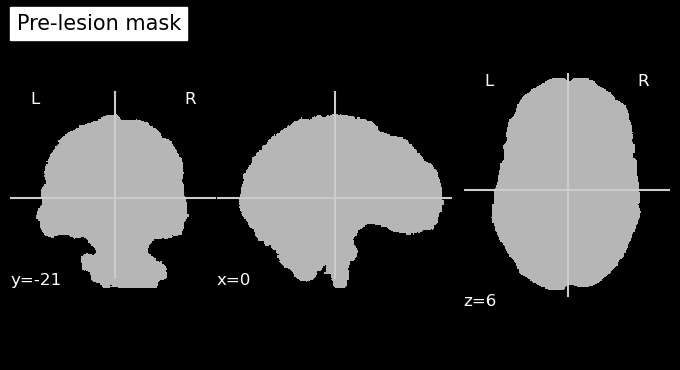

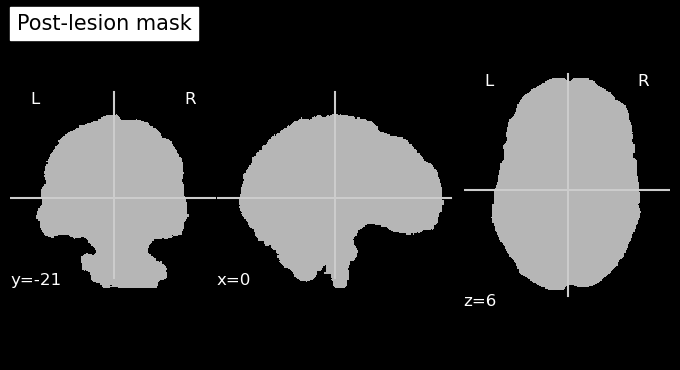

In [11]:

# load random mask from BRATS

# Load normal image

# make pre lesion as lesion core

# make post lesion as full lesion

# plot

t1_data = ni.load_img(random_normal_t1).get_fdata()
t1_mask_data = np.uint16(ni.load_img(random_normal_t1[:-7] + '.mask.nii.gz').get_fdata())
t1_seg_data = np.uint16(ni.load_img(random_lesion_segmentation).get_fdata())



pre_lesion_mask = np.uint16((t1_mask_data>0) & (t1_seg_data!=1))

post_lesion_mask = np.uint16((t1_mask_data>0) & (t1_seg_data<=0))

pre_lesion_mask_img = ni.new_img_like(random_normal_t1, pre_lesion_mask)
post_lesion_mask_img = ni.new_img_like(random_normal_t1, post_lesion_mask)

pre_lesion_mask_img.to_filename('/deneb_disk/auto_resection/lesion_masks/lesion_init.mask.nii.gz')
post_lesion_mask_img.to_filename('/deneb_disk/auto_resection/lesion_masks/lesion11.mask.nii.gz')


pre_lesion = ni.load_img('/deneb_disk/auto_resection/lesion_masks/lesion_init.mask.nii.gz')
post_lesion = ni.load_img('/deneb_disk/auto_resection/lesion_masks/lesion11.mask.nii.gz')

plot_anat(pre_lesion, title='Pre-lesion mask')
plot_anat(post_lesion, title='Post-lesion mask')


In [ ]:

from warper_incompressible import Warper

nonlin_reg = Warper()
pre2post_lesion = '/deneb_disk/auto_resection/lesion_masks/pre2post_lesion_incompressible.nii.gz'
ddf = '/deneb_disk/auto_resection/lesion_masks/pre2post_lesion_ddf_incompressible.nii.gz'
jac_file = '/deneb_disk/auto_resection/lesion_masks/pre2post_lesion_jac_incompressible.nii.gz'
nonlin_reg.nonlinear_reg(
    target_file=post_lesion,
    moving_file=pre_lesion,
    output_file=pre2post_lesion,
    ddf_file=ddf,
    reg_penalty=1e-3,
    nn_input_size=64,
    lr=1e-3,
    max_epochs=3000,
    loss="mse",
    jacobian_determinant_file=jac_file)


In [ ]:
from warp_utils import apply_warp
from monai.transforms import LoadImage, EnsureChannelFirst
import nibabel as nib

mri = '/deneb_disk/auto_resection/lesion_masks/USCBrain.nii.gz'
plot_anat(mri, title='MRI', cut_coords=cross_hair)

plot_anat(pre2post_lesion, title='Pre2post lesion mask', cut_coords=cross_hair)

moving = LoadImage(image_only=True)(pre_lesion)
moving = EnsureChannelFirst()(moving)[None]
target = LoadImage(image_only=True)(post_lesion)
target = EnsureChannelFirst()(target)[None]
disp = LoadImage(image_only=True)(ddf)
disp = EnsureChannelFirst()(disp)[None]
mri = LoadImage(image_only=True)(mri)
mri = EnsureChannelFirst()(mri)[None]

output_file='/deneb_disk/auto_resection/lesion_masks/pre2post_lesion_check_incompressible.nii.gz'
moved = apply_warp(disp_field=disp, moving_image=moving, target_image=target)
nib.save(nib.Nifti1Image(moved[0, 0].detach().cpu().numpy(), target.affine), output_file)


target = LoadImage(image_only=True)(post_lesion)
target = EnsureChannelFirst()(target)[None]
disp = LoadImage(image_only=True)(ddf)
disp = EnsureChannelFirst()(disp)[None]
#mri = LoadImage(image_only=True)(mri)
#mri = EnsureChannelFirst()(mri)[None]
output_file='/deneb_disk/auto_resection/lesion_masks/pre2post_mri_incompressible.nii.gz'
moved = apply_warp(disp_field=disp, moving_image=mri, target_image=target)
nib.save(nib.Nifti1Image(moved[0, 0].detach().cpu().numpy(), target.affine), output_file)


In [ ]:

lesion_file = '/deneb_disk/auto_resection/lesion_masks/lesion_init0.mask.nii.gz'
lesion_mri = '/deneb_disk/auto_resection/lesion_masks/USCBrain.pre_lesion.nii.gz'

target = LoadImage(image_only=True)(post_lesion)
target = EnsureChannelFirst()(target)[None]
disp = LoadImage(image_only=True)(ddf)
disp = EnsureChannelFirst()(disp)[None]
lesion = LoadImage(image_only=True)(lesion_file)
lesion = EnsureChannelFirst()(lesion)[None]
lesion = mri + lesion
nib.save(nib.Nifti1Image(lesion[0, 0].detach().cpu().numpy(), target.affine), lesion_mri)

output_file='/deneb_disk/auto_resection/lesion_masks/pre2post_lesion_incompressible.nii.gz'
moved = apply_warp(disp_field=disp, moving_image=lesion, target_image=target)
nib.save(nib.Nifti1Image(moved[0, 0].detach().cpu().numpy(), target.affine), output_file)


plot_anat(lesion_mri, title='Pre lesion mask', cut_coords=cross_hair)
plot_anat(output_file, title='Pre2post lesion mask', cut_coords=cross_hair)
